--- 
description: Here we show how to solve Hamiltonian cycles and paths problem using JijZept and JijModeling.
---

# Hamiltonian Cycles and Paths

Here we show how to solve the Hamiltonian cycles and paths problem using JijZept and JijModeling.
This problem is also mentioned in 7.1. Hamiltonian Cycles and Paths on [Lucas, 2014, "Ising formulations of many NP problems"](https://www.frontiersin.org/articles/10.3389/fphy.2014.00005/full).

## What are Hamiltonian Cycles and Paths?

The Hamiltonian path problem is defined as follows.
Starting from a vertex in given graph, make a travel along the edges so that the traveler visits every vertex exactly once.
The Hamiltonian cycles problem requires in addition that the traveler should return to the starting vertex (*i.e.* the traveler visits the starting point twice.).
Note that the graph can either be directed or undirected.


## Mathematical model

Without loss of generality, we label the vertices by $1, \cdots , V$ and assume the edges are directed; *i.e.* $(uv)$ and $(vu)$ denote different edges from each other.
For the given graph $G = (V, E)$, we consider that a vertex $v$ is visited in the $i$-th step if a binary variable $x_{v,i}$ is $1$, and vice versa.

**Constraint 1: every vertex in the graph must be visited exactly once**

This constraint can be formulated in a quite simple way:

$$
\quad \sum_{i=1}^V x_{v, i}  = 1 \quad \text{for } v = 1, \cdots , V.
$$

**Constraint 2: the path must be connected**

This means that there must be only one $i$-th vertex in the cycle for each $i$.

$$
\quad \sum_{v=1}^V x_{v, i} = 1 \quad \text{for } v = 1, \cdots , V.
$$

The following figure illustrates a valid path,
and you can count the number of variables that take $1$ for each row and column to confirm the above two conditions held.

![](./assets/20-hamiltonian_cycles_and_paths.jpg)

**Constraint 3: an edge $(u, v)$ must be in $G$ if it is used in the path**

If an edge $(u,v)$ is used in the path, both $x_{u,i}$ and $x_{v,i+1}$ take $1$,
so that this constraint is formulated as below.

$$
\quad \sum_{(u,v) \notin E} \sum_{i=1}^{V} x_{u,i} x_{v, (i+1)\%V} = 0
$$

Note that this constraint should be considered for the Hamiltonian cycles problem.
As for the Hamiltonian paths problem instead, one relaxes the condition a bit by changing $\sum_{i=1}^V$ to $\sum_{i=1}^{V-1}$;
this means that we do not have to care about the edge between the first and the last vertices.


## Modeling by JijModeling

We show how to implement above equations using JijModeling.
We first define the variables in the mathematical model described above.


In [3]:
import jijmodeling as jm

# define variables
V = jm.Placeholder('V')
barE = jm.Placeholder('barE', ndim=2)
num_barE = barE.shape[0]
i = jm.Element('i', V)
v = jm.Element('v', V)
x = jm.BinaryVar('x', shape=(V, V))
f = jm.Element('f', num_barE)

The constraints are written as:


In [4]:
problem = jm.Problem("Hamiltonian Cycles")
problem += jm.Constraint('one-vertex', x[v, :].sum()==1, forall=v)
problem += jm.Constraint('one-path', x[:, i].sum()==1, forall=i)
problem += jm.Constraint('one-edge', jm.sum([f,i], x[barE[f][0],i]*x[barE[f][1],(i+1)%V])==0)

On Jupyter Notebook, one can check the problem statement in a human-readable way by hitting


In [5]:
problem

## Prepare an instance

We prepare a graph using [Networkx](https://networkx.org/).


In [6]:
import networkx as nx

# set empty graph
inst_G = nx.DiGraph()
# add edges
for u,v in [[0,1], [0,2], [0,3], [1,4], [2,3], [3,4]]:
    inst_G.add_edge(u,v)
    inst_G.add_edge(v,u)
inst_barE = []
for u,v in list(nx.complement(inst_G).edges):
    inst_barE.append([u,v])

# get the number of vertex
inst_V = list(inst_G.nodes)
num_V = len(inst_V)

instance_data = {'V': num_V, 'barE': inst_barE}


This graph is shown below.

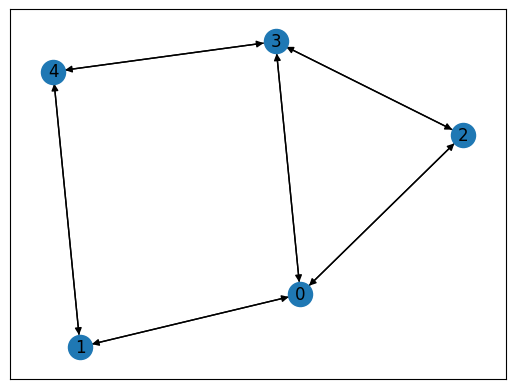

In [7]:
import matplotlib.pyplot as plt

# Compute the layout
pos = nx.spring_layout(inst_G)

nx.draw_networkx(inst_G, pos=pos, with_labels=True)
plt.show()

## Solve by JijZept's SA

We solve this problem using JijSASampler.


In [8]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config="../../../config.toml")
# solve problem
response = sampler.sample_model(problem, instance_data, multipliers={"one-vertex": 0.5, "one-path": 0.5, "one-edge": 0.5}, search=True, num_reads=100)

## Visualize the solution

The result can be seen as below.


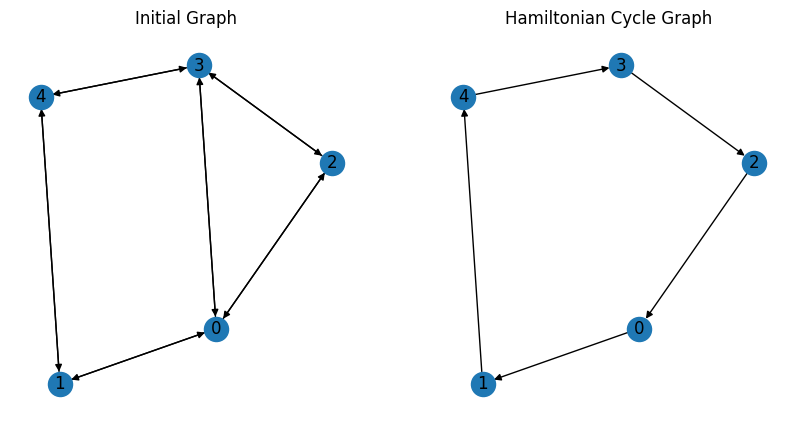

In [9]:
import matplotlib.pyplot as plt

# get sampleset
sampleset = response.get_sampleset()
# extract feasible samples
feasible_samples = sampleset.feasibles()
if len(feasible_samples) == 0:
    print("No feasible sample found ...")
else:
    # get a feasible solution
    feasible_solution = feasible_samples[0].var_values["x"].values
    # get the indices of x == 1
    x_indices = feasible_solution.keys()
    # sort by time step
    path = [index for index, _ in sorted(x_indices, key=lambda x: x[1])]
    # append start point
    path.append(path[0])    
    # make the directed graph from paths
    inst_DG = nx.DiGraph()
    inst_DG.add_edges_from([(path[i], path[i+1]) for i in range(len(path)-1)])
    # create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    # draw the initial graph
    nx.draw_networkx(inst_G, pos, with_labels=True, ax=ax1)
    ax1.set_title('Initial Graph')
    plt.axis('off')
    ax1.set_frame_on(False) # Remove the frame from the first subplot
    # draw the directed graph
    nx.draw_networkx_nodes(inst_DG, pos)
    nx.draw_networkx_edges(inst_DG, pos, arrows=True)
    nx.draw_networkx_labels(inst_DG, pos)
    plt.axis('off')
    ax2.set_title('Hamiltonian Cycle Graph')
    # show the graphs
    plt.show()

As expected, we obtain a Hamiltonian cycle.